In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline



In [73]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fd63128>,
      dtype=object)

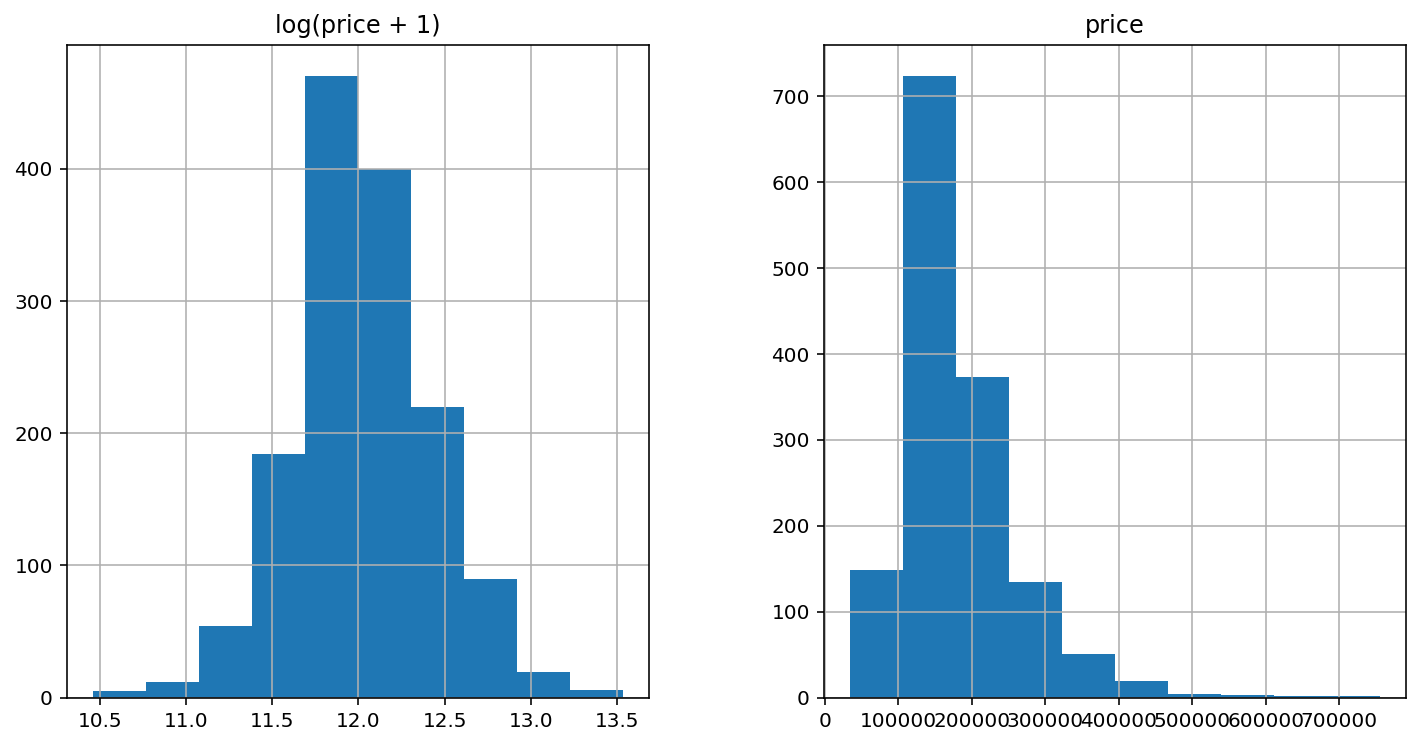

In [74]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [75]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

/Users/Nithanth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log1p
  # This is added back by InteractiveShellApp.init_path()


In [76]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [112]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

rr = Ridge(alpha=0.1, normalize = True)
rr.fit(X_train, y)

predicted_rr = np.expm1(rr.predict(X_test))
table = pd.DataFrame({"ID": test["Id"], "Sale Price": predicted_rr})
print("Prediction Table Sample:")
display(table.head(n=10))

rmse_rr = rmse_cv(rr).mean()
print("RMSE for Ridge Regression:", rmse_rr)







Prediction Table Sample:


,ID,Sale Price
0,1461,123297.660144
1,1462,158914.633990
2,1463,183375.202021
3,1464,197770.084726
4,1465,198958.131171
5,1466,169418.272082
6,1467,173070.472414
7,1468,162221.960578
8,1469,190239.416905
9,1470,121044.844193


RMSE for Ridge Regression: 0.13272666670953315


In [113]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 30, 50]

rr_cv = RidgeCV(alphas = alphas, cv = 5).fit(X_train, y)
ls_cv = LassoCV(alphas = alphas, cv = 5).fit(X_train, y)

predicted_rr_cv = np.expm1(rr_cv.predict(X_test))
predicted_ls_cv = np.expm1(ls_cv.predict(X_test))

print("Ridge Regression Predicted Sale Price:")
rr_table = pd.DataFrame({"Id": test["Id"], "SalePrice": predicted_rr_cv})
display(rr_table.head(n=10))

print("Lasso Regression Predicted Sale Price:")
ls_table = pd.DataFrame({"Id": test["Id"], "SalePrice": predicted_ls_cv})
display(ls_table.head(n=10))

print("RMSE for Ridge Regression:", rmse_cv(rr_cv).mean(), "VS RMSE for Lasso Regression:", rmse_cv(ls_cv).mean())

rr_table.to_csv("ridge.csv", encoding='utf-8', index=False)
ls_table.to_csv("lasso.csv", encoding='utf-8', index=False)





Ridge Regression Predicted Sale Price:


,Id,SalePrice
0,1461,119029.139495
1,1462,153034.778689
2,1463,181011.214251
3,1464,197891.150498
4,1465,200308.085076
5,1466,166881.942478
6,1467,178263.220973
7,1468,160936.137123
8,1469,189803.447287
9,1470,121717.178308


Lasso Regression Predicted Sale Price:


,Id,SalePrice
0,1461,119251.221114
1,1462,150256.759467
2,1463,179589.907042
3,1464,200250.739786
4,1465,201513.989979
5,1466,170571.486098
6,1467,182241.439178
7,1468,160611.645117
8,1469,197676.413875
9,1470,116695.305655


RMSE for Ridge Regression: 0.1276558204028946 VS RMSE for Lasso Regression: 0.12419498942266942


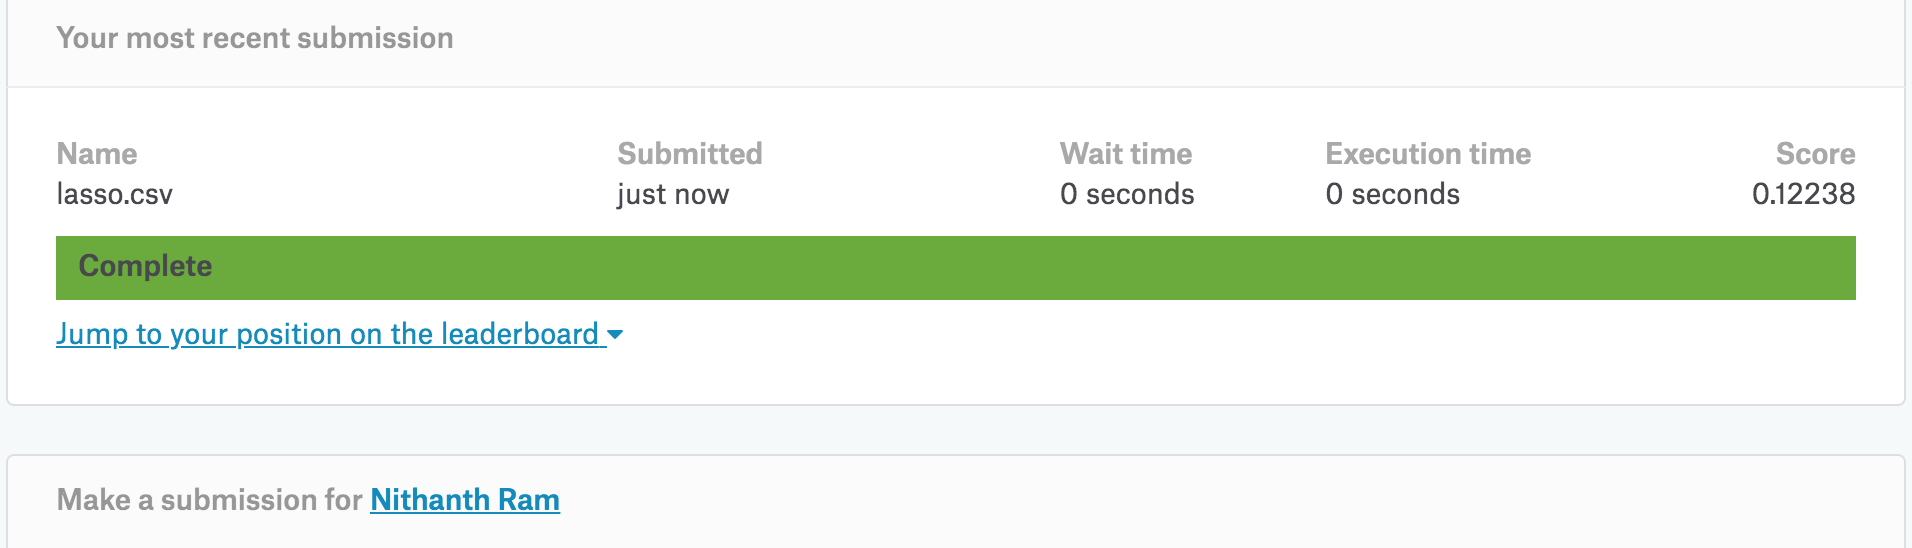

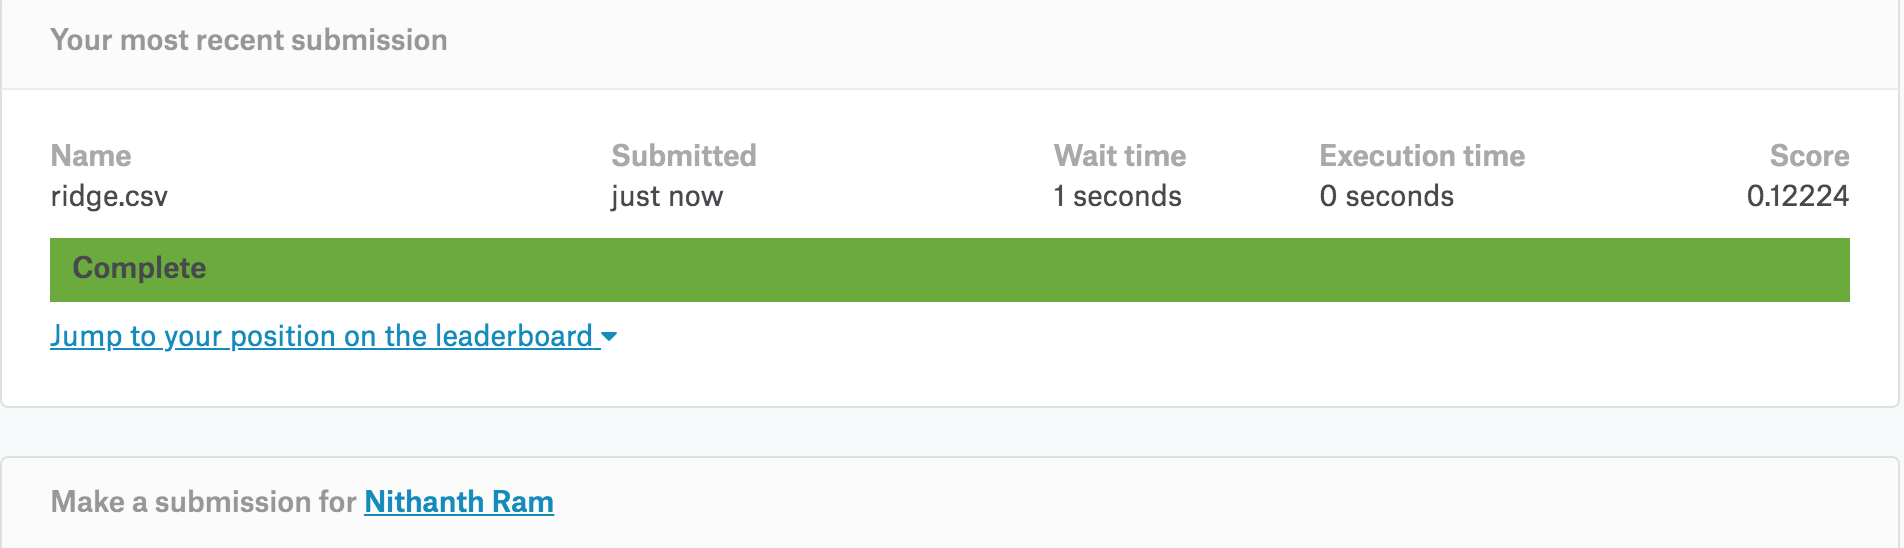

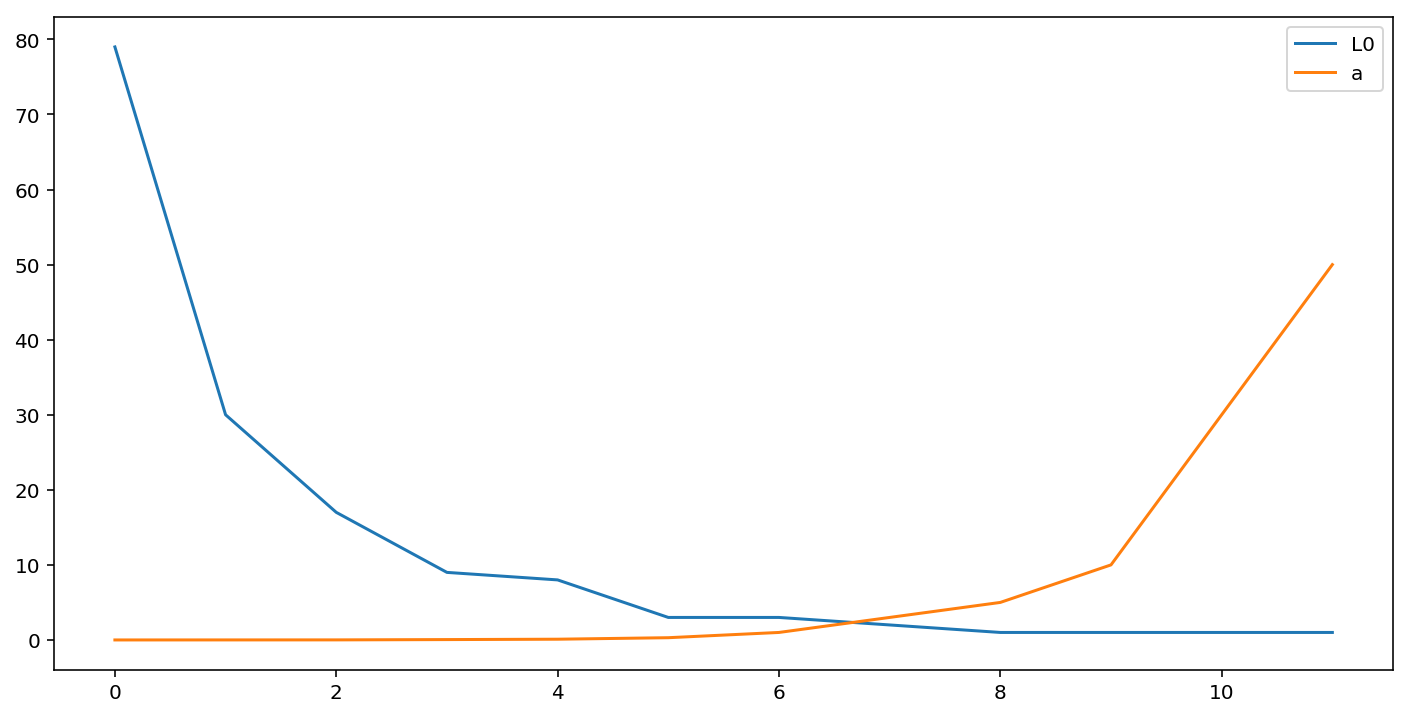

In [121]:
L0 = []
for alpha in alphas:
    lasso = Lasso(alpha).fit(X_train, y)
    L0.append({"a": alpha, "L0": sum(lasso.coef_ != 0)})

pd.DataFrame(L0).plot()